<a href="https://colab.research.google.com/github/geekpradd/Reinforcement-Learning-Stock-Trader/blob/master/New_Stock_Updated1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import gym
from gym import spaces
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import random
from tensorflow.keras.layers import Dense, Concatenate, Lambda, Activation
from tensorflow.keras import Input
from tensorflow import convert_to_tensor as convert
from collections import deque
import pickle
# COLAB = False
# if not COLAB:
#     import os
#     os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
path_base = ''
import os

In [2]:
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, params, train = True):
        super(StockEnv,self).__init__()
        
        self.num_stocks = params['num_stocks']
        self.min_brokerage = params['min_brokerage']
        self.brokerage_rate = params['brokerage_rate']
        self.balance_normal = params['balance_normal']
        self.shares_normal = params['shares_normal']
        self.volume_normal = params['volume_normal']
        self.dfs = df
        self.state_dimensions = self.num_stocks*5+1
        self.train = train

        assert len(df) == self.num_stocks, "Size of database not equal to number of stocks"

        self.max_steps = min([len(d.loc[:,'Open']) for d in self.dfs])
        self.action_space = spaces.Box(low = -1, high = 1, shape =  (1, self.num_stocks*2), dtype = np.float32)
        self.observation_space = spaces.Box(low = 0, high = 1, shape = (1, self.state_dimensions), dtype = np.float32)

    def reset(self, intial_balance = 10000, shares_held = None):

        if self.train:
            self.current_step = np.random.randint(0, self.max_steps)
        else:
            self.current_step = 0
        print('current_step',self.current_step)
        self.balance = intial_balance
        self.shares_held = shares_held
        if self.shares_held is None:
            self.shares_held = np.zeros((1, self.num_stocks))
        self.current_price = self.get_price()
        self.highest_price = 0
        self.net_worth = self.balance + np.sum(self.shares_held*self.current_price)
        self.initial_worth = self.net_worth
        self.max_net_worth = self.net_worth
        self.set_high()
        self.done = False
        self.frame = np.zeros((1, self.state_dimensions))
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance,
        }
        return self.observe()
        
    def get_price(self):
#         for df in self.dfs:
#             #print(self.current_step, [df.loc[self.current_step,"Low"], df.loc[self.current_step,"High"]])
        return np.array([np.random.uniform(df.loc[self.current_step,"Low"], df.loc[self.current_step,"High"]) for df in self.dfs]).reshape((1, self.num_stocks))
      
    def set_high(self):
        high = np.array([df.loc[self.current_step, 'High'] for df in self.dfs]).reshape((1, self.num_stocks))
        self.highest_price = np.maximum(self.highest_price, high)
        for i in range(self.highest_price.shape[1]):
            if not np.isfinite(self.highest_price[0][i]):
                self.highest_price[0][i]=1

    def observe(self):
        for i in range(self.num_stocks):
            self.frame[0, 4*i:4*i+4] = np.array([self.dfs[i].loc[self.current_step,'Open'],self.dfs[i].loc[self.current_step,'High'],self.dfs[i].loc[self.current_step,'Low'],self.dfs[i].loc[self.current_step,'Close']])/self.highest_price[0, i]
        self.frame[0, self.num_stocks*4:self.num_stocks*5] = self.shares_held/self.shares_normal
        self.frame[0, 5*self.num_stocks] = self.balance/self.balance_normal
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance
        }
        return self.frame, self.info
    
    def update_worth(self, reward):
        self.net_worth += reward
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def update_balance(self, action):
        self.balance += np.sum(action[:, :self.num_stocks]*self.current_price)
        self.balance -= np.sum(action[:, self.num_stocks:]*self.current_price)

    def update_shares(self, action):
        self.shares_held -= action[:, :self.num_stocks]
        self.shares_held +=  action[:, self.num_stocks:]

    def take_action(self, action):
        self.current_price = self.get_price()
        action[:, :self.num_stocks] = np.floor(action[:, :self.num_stocks] *self.shares_held)
        if not np.isfinite(self.current_price).all():
            print('gadbad in current price')
            self.current_price=np.ones(self.current_price.shape)
        action[:, self.num_stocks:] = np.floor(action[:, self.num_stocks:] * self.balance / self.current_price)
        self.set_high()
        self.update_balance(action)
        self.update_shares(action)
        reward = self.balance + np.sum(self.shares_held * self.current_price) - self.net_worth
        self.update_worth(reward)
        return reward
            
    def step(self, action):
        self.current_step += 1
        if self.current_step >= self.max_steps or self.done:
            self.done = True
            return np.zeros((1, self.state_dimensions)), 0, self.done, self.info
        if np.sum(action[:, self.num_stocks:]) > 1:
            print('gadbad')
        reward = self.take_action(action)
        self.done = self.net_worth <= self.initial_worth*0.05
        if self.done:
            print('snap')
        obs, info = self.observe()
        return obs, reward, self.done, info
    
    def render(self, mode='human', close = False):
        profit = self.net_worth - self.initial_worth
        print('Step: {}'.format(self.current_step))
        print('Net Worth: {}'.format(self.net_worth))
        print('Profit: {}'.format(profit))
        
def create_stock_env(locations, train=True):
    dfs = [pd.read_csv(location).sort_values('Date') for location in locations]
    params = {
        'num_stocks' : len(locations),
        'min_brokerage' : 30.0,
        'brokerage_rate' : 0.001,
        'balance_normal' : 1000000,
        'shares_normal' : 10000,
        'volume_normal' : 2147483647,
    }
    return StockEnv(dfs, params, train)

In [3]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.size = buffer_size
        self.buffer = deque()
        
    def append(self, data_tuple):
        self.buffer.append(data_tuple)
        if len(self.buffer) > self.size:
            self.buffer.popleft()
            
    def sample(self, sample_size):
        size = min(len(self.buffer), sample_size)
        return random.sample(self.buffer, size), size
        
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [4]:
class Actor:
    def __init__(self, params):
        self.output_range = params["output_range"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.cap = params['cap']
        self.actor = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=(self.state_dimensions, ))
        x = Dense(1024, activation = 'relu')(inputs)
        x = Dense(256, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        sell = Dense(self.action_dimensions, activation = 'sigmoid')(x)
        buy = Dense(self.action_dimensions, activation = 'sigmoid')(x)
        final_buy = Activation(tf.keras.activations.softmax)(buy)*tf.math.minimum(self.cap, tf.reduce_sum(buy, axis = -1, keepdims = True))
        model = keras.Model(inputs = inputs, outputs = tf.concat([sell, final_buy], axis = -1))
        # model.summary()
        return model
    
    def get_action(self, state):
        return self.actor(convert(state))

    def save(self):
        self.actor.save(path_base + 'actor.h5')
    
    def load(self):
        self.actor = keras.models.load_model(path_base + 'actor.h5')
        print('Successfully Loaded')

class Critic:
    def __init__(self, params):
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.optimizer = params["critic_optimizer"]
        self.tau = params['tau']
        self.critic_online = self.build_model()
        self.critic_target = self.build_model()
        self.critic_online.set_weights(self.critic_target.get_weights())

    def build_model(self):
        input_a = Input(shape = (self.state_dimensions, ))
        input_b = Input(shape = (2*self.action_dimensions, ))
        input = Concatenate(axis = -1)([input_a, input_b])
        x = Dense(1024, activation = 'relu')(input)
        x = Dense(256, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        output = Dense(1)(x)
        model = keras.Model(inputs=[input_a, input_b], outputs = output)
        model.compile(loss='mse', optimizer = keras.optimizers.Adam(learning_rate = 0.001))
        # model.summary()
        return model

    def save(self):
        self.critic_online.save(path_base + 'critic_online.h5')
        self.critic_target.save(path_base + 'critic_target.h5')

    def load(self):
        self.critic_online = keras.models.load_model(path_base + 'critic_online.h5')
        self.critic_target = keras.models.load_model(path_base + 'critic_target.h5')

    def get_qvalues(self, state_array, action_array, online=True):
        if online:
            return self.critic_online([convert(state_array), convert(action_array)])
        else:
            return self.critic_target([convert(state_array), convert(action_array)])

    def call(self, state_tensor, action_tensor):
        return self.critic_online([state_tensor, action_tensor])
    
    def merge(self):
        self.critic_target.set_weights(self.tau*np.array(self.critic_online.get_weights())
                                                                    + (1-self.tau)*np.array(self.critic_target.get_weights()))

In [5]:
class Agent:
    def __init__(self, params, train = True, resume = True):
        self.back_state = 20
        self.train = train
        params["state_dimensions"]=params['state']*self.back_state
        self.actor = Actor(params)
        self.critic = Critic(params)
        self.buffer = ReplayBuffer(params["buffer_size"])
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.discount = params["discount"]
        self.action_range = params["output_range"]
        self.save_frequency = params["save_frequency"]
        self.batch_size = params["batch_size"]
        self.optimizer = params["actor_optimizer"]
        self.cap = params['cap']
        self.num_steps = 0
        self.state = np.zeros((self.back_state,self.state_dimensions//self.back_state))
        self.have_state = 1
        self.noise_func =  OrnsteinUhlenbeckActionNoise(mu=np.zeros(2*params["action_dimensions"]))
        if resume:
            self.load()
    def agent_start(self):
        self.state = np.zeros((self.back_state,self.state_dimensions//self.back_state))
        self.have_state=1
#         if self.train:
#             action = self.clip_action(action + self.noise_func())
#         else:
#             action = self.clip_action(action)

    def clip_action(self, action):
        action = np.clip(action, 0, self.action_range)
        sum = np.sum(action, axis = -1, keepdims = True)
        if sum==0:
            return action
        action = action*np.minimum(sum, self.cap)/sum
        return action
        
    def agent_step(self, reward, observation):
#         print(self.state)
#         print(self.state.shape)
        if self.have_state < self.back_state:
            action = np.zeros((1,self.action_dimensions*2))
            self.state[self.have_state-1] = observation
            self.have_state += 1
            self.prev_action = action
            self.prev_state = np.reshape(self.state, [1,self.state_dimensions])
            return self.prev_action
        if self.have_state == self.back_state:
            self.state[-1] = observation
            #print(self.state)
            action = self.actor.get_action(np.reshape(self.state, [1,self.state_dimensions]))
            if self.train:
                action = self.clip_action(action + self.noise_func())
            else:
                action = self.clip_action(action)
            self.prev_state = np.reshape(self.state, [1,self.state_dimensions])
            self.prev_action = action
            self.have_state+=1
            return self.prev_action
        
#         print(self.state.shape)
        self.state = self.state[1:,:]
        self.state = np.append(self.state,observation,axis=0)
#         print(self.state)
#         print(self.state.shape)
        state = np.reshape(self.state, [1,self.state_dimensions])
        if self.train:
            replay = (self.prev_state, self.prev_action, reward, state)
            self.buffer.append(replay)
            
        action = self.actor.get_action(state)
        if self.train:
            action = self.clip_action(action + self.noise_func())
            self.run()
        else:
            action = self.clip_action(action)
        self.prev_action = action
        self.prev_state = state
        return self.prev_action 
    
    def save(self):
        print('saving')
        self.actor.save()
        self.critic.save()
        data = (self.buffer, self.num_steps, self.noise_func)
        with open (path_base + 'auxiliary.pkl', 'wb') as f:
            pickle.dump(data, f)

    def load(self):
        print('loading')
        self.actor.load()
        self.critic.load()
#         with open (path_base + 'auxiliary.pkl', 'rb') as f:
#             data = pickle.load(f)
#         self.buffer, self.num_steps, self.noise_func = data
    
    def run(self):
        self.num_steps += 1
        size = min(self.batch_size, self.buffer.size)
        batch,_ = self.buffer.sample(size)
        prev_states = np.array([x[0] for x in batch]).reshape((-1, self.state_dimensions))
        prev_actions = np.array([x[1] for x in batch]).reshape((-1, 2*self.action_dimensions))
        rewards = np.array([x[2] for x in batch]).reshape((-1, 1))
        states = np.array([x[3] for x in batch]).reshape((-1, self.state_dimensions))
        actions = self.actor.get_action(states)
        q_values = self.critic.get_qvalues(states, actions, False)
        q_values += self.discount*rewards
        self.critic.critic_online.fit([states, actions], q_values, epochs = 1, verbose=0)

        prev_state_tensor = convert(prev_states)
        prev_action_tensor = convert(prev_actions)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(prev_action_tensor)
            value = self.critic.call(prev_state_tensor, prev_action_tensor)
            action = self.actor.actor(prev_state_tensor)
        gradient = -tape.gradient(value, prev_action_tensor)
        gradient = tf.cast(gradient, tf.float32)
        gradient_actor = tape.gradient(action, self.actor.actor.trainable_weights, gradient)
        gradient_actor = list(np.array(gradient_actor)/size)

        self.optimizer.apply_gradients(zip(gradient_actor, self.actor.actor.trainable_weights))
        self.critic.merge()

        if self.num_steps % self.save_frequency == 0:
            self.save()

In [6]:
epochs_per_iter = 10

def train(agent, env, epochs, profits, balances, shares, actions):

    steps_per_epoch = 2000
    
    for epoch in range(epochs, epochs + epochs_per_iter+1):

        cumm_profit = 0
        observation, info = env.reset()
        shares[epoch, 0, :] = info['shares_held']
        balances[epoch, 0] = info['balance']
        agent.agent_start()
        action = agent.agent_step(0,observation)
        actions[epoch, 0, :] = action

        for i in tqdm(range(steps_per_epoch)):

            observation, reward, done, info = env.step(action)
            shares[epoch, i+1, :] = info['shares_held']
            balances[epoch, i+1] = info['balance']
            cumm_profit += reward
            profits[epoch, i] = cumm_profit
            if done:
                break
            action = agent.agent_step(reward, observation)
#             if i%400==0:
#                 print(i,action)
            if not np.isfinite(action).all():
                for att in vars(agent):
                    print (att, getattr(agent,att))
                print('--------------------------------------------------------------------------------------------------')
                for att in vars(agent.actor):
                    print (att, getattr(agent.actor,att))
                print('--------------------------------------------------------------------------------------------------')
                # print(--------------------------------------------------------------------------------------------------------)
                for att in vars(agent.critic):
                    print (att, getattr(agent.critic,att)) 
                print('--------------------------------------------------------------------------------------------------')
                #print(--------------------------------------------------------------------------------------------------------)
                for att in vars(env):
                    print (att, getattr(env,att))
                print('--------------------------------------------------------------------------------------------------')
                #     print(--------------------------------------------------------------------------------------------------------)
                break
                for name, value in globals().items():
                     print(name, value)
            actions[epoch, i+1, :] = action
#         print(action)
        print('Completed epoch' + str(epoch),profits[epoch,i])

        if epoch % 10 == 0:
            data = epoch, profits, shares, balances, actions
            with open(path_base + 'graph.pkl', 'wb') as f:
                pickle.dump(data, f)

In [7]:
AGENT_PARAMS = {
	"output_range": 1,
	"state": 11,
	"action_dimensions": 2,
	"critic_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.0001),
	"actor_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.00005),
	"batch_size": 64,
	"buffer_size":100000,
	"discount": 0.99,
	"tau": 0.001,
	"save_frequency": 5000,
	'cap' : 0.9,
}

In [8]:
stocks = ['IBM.csv','GOOG.csv', 'AAPL.csv', 'MSFT.csv','AMZN.csv','DXC.csv','INFY.csv','M.csv','PCG.csv', 'PNB.csv', 'RELIN.csv','BPCL.csv']
files = ['M.csv','PCG.csv']
env = create_stock_env(files,train= True)
tf.keras.backend.set_floatx('float32')
agent = Agent(AGENT_PARAMS, train = True,resume = True)

loading
Successfully Loaded


In [70]:
steps_per_epoch = 2000
print(agent.num_steps)
stocks = ['IBM.csv','AMZN.csv','DXC.csv','INFY.csv','M.csv','PCG.csv','RELIN.csv']
#while epochs<600:
# data = [0,np.zeros((50*epochs_per_iter,steps_per_epoch)),np.zeros((50*epochs_per_iter,steps_per_epoch+1,2)),np.zeros((50*epochs_per_iter,1+steps_per_epoch)),np.zeros((50*epochs_per_iter,1+steps_per_epoch,4))]    
for f in stocks:
    with open(path_base + 'graph.pkl', 'rb') as fi:
        data = pickle.load(fi)
    files = ['AAPL.csv',f]
    print(files)
    env = create_stock_env(files,train= True)
    epochs, profits, shares, balances, actions = data
    train(agent, env, epochs, profits, balances, shares, actions)
    epochs+=epochs_per_iter
    for i in range(25):
        os.system("printf '\a'")

390


  1%|          | 21/2000 [00:00<00:10, 182.43it/s]

['AAPL.csv', 'IBM.csv']
current_step 9629


 17%|█▋        | 334/2000 [00:13<01:08, 24.32it/s]


Completed epoch30 2595.0483464307836


  1%|          | 21/2000 [00:00<00:09, 198.10it/s]

current_step 4164


  1%|          | 22/2000 [00:00<00:12, 162.52it/s]

Completed epoch31 58307.60412855663
current_step 4010


  1%|          | 21/2000 [00:00<00:09, 209.78it/s]

Completed epoch32 22342.557309812666
current_step 7962


 18%|█▊        | 353/2000 [00:14<01:31, 17.95it/s]

saving


  1%|          | 21/2000 [00:00<00:09, 203.52it/s]

Completed epoch33 30935.34610963674
current_step 7128


  1%|          | 22/2000 [00:00<00:12, 159.11it/s]

Completed epoch34 7364.796278505066
current_step 4078


 69%|██████▉   | 1387/2000 [01:00<00:26, 22.99it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 157.09it/s]

Completed epoch35 6968.066076567371
current_step 3261


  1%|          | 20/2000 [00:00<00:18, 105.72it/s]

Completed epoch36 4598.960670758728
current_step 8172


  1%|          | 21/2000 [00:00<00:12, 163.87it/s]

Completed epoch37 22450.836038414494
current_step 5558


 33%|███▎      | 654/2000 [00:56<01:34, 14.20it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 162.20it/s]

Completed epoch38 10648.908557590887
current_step 5488


  1%|          | 22/2000 [00:00<00:12, 158.32it/s]

Completed epoch39 24964.411912184107
current_step 4625


 85%|████████▍ | 1692/2000 [01:13<00:13, 22.70it/s]

saving


100%|██████████| 2000/2000 [01:27<00:00, 22.88it/s]


Completed epoch40 25136.419700235827


  1%|          | 21/2000 [00:00<00:10, 196.18it/s]

['AAPL.csv', 'AMZN.csv']
current_step 5543


 13%|█▎        | 269/2000 [00:10<01:10, 24.60it/s]


Completed epoch40 1308.298227140618


  1%|          | 21/2000 [00:00<00:11, 170.49it/s]

current_step 4678


  1%|          | 22/2000 [00:00<00:12, 155.49it/s]

Completed epoch41 4557.050897495217
current_step 4047


  1%|          | 21/2000 [00:00<00:09, 206.25it/s]

Completed epoch42 7014.7850013733005
current_step 1424


 80%|████████  | 1601/2000 [01:10<00:18, 21.74it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 157.96it/s]

Completed epoch43 7646.084850088169
current_step 3867


  1%|          | 22/2000 [00:00<00:12, 154.96it/s]

Completed epoch44 10220.275668564424
current_step 2595


  1%|          | 22/2000 [00:00<00:12, 158.97it/s]

Completed epoch45 2054.163965054262
current_step 3582


 36%|███▌      | 711/2000 [00:31<00:58, 22.11it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 154.18it/s]

Completed epoch46 4652.120074620827
current_step 1077


  1%|          | 22/2000 [00:00<00:12, 156.84it/s]

Completed epoch47 17214.776269136066
current_step 5574


  1%|          | 22/2000 [00:00<00:12, 158.85it/s]

Completed epoch48 -262.6585087470703
current_step 3951


 76%|███████▋  | 1530/2000 [01:08<00:21, 22.16it/s]

saving


  1%|          | 21/2000 [00:00<00:09, 206.41it/s]

Completed epoch49 5524.52895787359
current_step 2116


100%|██████████| 2000/2000 [01:30<00:00, 22.15it/s]


Completed epoch50 8914.392886151662


  1%|          | 21/2000 [00:00<00:10, 189.06it/s]

['AAPL.csv', 'DXC.csv']
current_step 5041


100%|██████████| 2000/2000 [01:30<00:00, 22.10it/s]


Completed epoch50 57773.4225256225


  1%|          | 21/2000 [00:00<00:10, 197.44it/s]

current_step 9154


  1%|          | 22/2000 [00:00<00:13, 148.77it/s]

Completed epoch51 907.9237023283531
current_step 5196


 10%|█         | 200/2000 [00:08<01:21, 22.13it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 152.17it/s]

Completed epoch52 51158.61855414508
current_step 3050


  1%|          | 21/2000 [00:00<00:09, 206.66it/s]

Completed epoch53 -1556.8222983702162
current_step 7317


 62%|██████▏   | 1239/2000 [00:56<00:34, 21.95it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 158.40it/s]

Completed epoch54 6298.40999193415
current_step 413


  1%|          | 21/2000 [00:00<00:09, 208.17it/s]

Completed epoch55 26464.605500972386
current_step 6716


  1%|          | 22/2000 [00:00<00:12, 159.39it/s]

Completed epoch56 10898.792750849512
current_step 7201


 15%|█▍        | 295/2000 [00:12<01:16, 22.22it/s]

saving


  1%|          | 21/2000 [00:00<00:09, 198.43it/s]

Completed epoch57 31741.658353623076
current_step 290


  1%|          | 22/2000 [00:00<00:12, 152.41it/s]

Completed epoch58 13678.689249347943
current_step 7611


 67%|██████▋   | 1333/2000 [01:00<00:30, 22.07it/s]

saving


  1%|          | 21/2000 [00:00<00:09, 204.92it/s]

Completed epoch59 11843.30956963242
current_step 3577


100%|██████████| 2000/2000 [01:31<00:00, 21.96it/s]


Completed epoch60 7338.103272665314


  1%|          | 21/2000 [00:00<00:10, 189.33it/s]

['AAPL.csv', 'INFY.csv']
current_step 4720


 32%|███▏      | 634/2000 [00:28<01:01, 22.28it/s]


Completed epoch60 -873.1003454542351


  1%|          | 21/2000 [00:00<00:10, 194.40it/s]

current_step 182


 88%|████████▊ | 1756/2000 [01:20<00:11, 21.23it/s]

saving


  1%|          | 21/2000 [00:00<00:09, 206.80it/s]

Completed epoch61 881.9737718126416
current_step 4440


  1%|          | 21/2000 [00:00<00:09, 201.04it/s]

Completed epoch62 3434.6133187431387
current_step 70


  1%|          | 21/2000 [00:00<00:09, 202.20it/s]

Completed epoch63 30262.195995881884
current_step 1988


 95%|█████████▌| 1900/2000 [01:26<00:04, 21.40it/s]

saving


  1%|          | 22/2000 [00:00<00:13, 149.56it/s]

Completed epoch64 3728.921406992122
current_step 2741


  1%|          | 21/2000 [00:00<00:10, 191.82it/s]

Completed epoch65 5518.962867582202
current_step 2433


  1%|          | 21/2000 [00:00<00:10, 197.53it/s]

Completed epoch66 5936.928580753924
current_step 1454


 48%|████▊     | 957/2000 [00:43<00:47, 21.75it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 156.00it/s]

Completed epoch67 21093.73069540978
current_step 1811


  1%|          | 21/2000 [00:00<00:10, 196.16it/s]

Completed epoch68 -2643.758033197306
current_step 138


100%|█████████▉| 1996/2000 [01:31<00:00, 21.06it/s]

saving


  1%|          | 21/2000 [00:00<00:10, 197.87it/s]

Completed epoch69 27185.105814387185
current_step 175


100%|██████████| 2000/2000 [01:32<00:00, 21.67it/s]


Completed epoch70 13455.433171945686


  1%|          | 21/2000 [00:00<00:10, 197.01it/s]

['AAPL.csv', 'M.csv']
current_step 3687


100%|██████████| 2000/2000 [01:32<00:00, 21.57it/s]


Completed epoch70 1360.65640696411


  1%|          | 21/2000 [00:00<00:11, 176.12it/s]

current_step 5963


 53%|█████▎    | 1053/2000 [00:48<00:43, 21.67it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 152.54it/s]

Completed epoch71 8346.912192681644
current_step 436


  1%|          | 22/2000 [00:00<00:13, 151.94it/s]

Completed epoch72 19551.118117381222
current_step 5272


  1%|          | 22/2000 [00:00<00:12, 157.15it/s]

Completed epoch73 -324.31708055624586
current_step 2369


 53%|█████▎    | 1051/2000 [00:47<00:43, 21.87it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 156.01it/s]

Completed epoch74 573.9791841608094
current_step 2622


  1%|          | 21/2000 [00:00<00:10, 185.93it/s]

Completed epoch75 973.4779364353053
current_step 6064


  1%|          | 21/2000 [00:00<00:09, 206.07it/s]

Completed epoch76 3303.0814387068767
current_step 4855


 51%|█████▏    | 1027/2000 [00:46<00:45, 21.46it/s]

saving


  1%|          | 22/2000 [00:00<00:13, 150.67it/s]

Completed epoch77 -4208.505660088887
current_step 4749


  1%|          | 21/2000 [00:00<00:09, 199.68it/s]

Completed epoch78 33626.48210150505
current_step 900


  1%|          | 22/2000 [00:00<00:11, 164.91it/s]

Completed epoch79 23113.901197244835
current_step 3348


  4%|▍         | 85/2000 [00:02<01:26, 22.17it/s] 

saving


100%|██████████| 2000/2000 [01:30<00:00, 22.05it/s]


Completed epoch80 2698.9015277627987


  1%|          | 21/2000 [00:00<00:10, 196.06it/s]

['AAPL.csv', 'PCG.csv']
current_step 2479


100%|██████████| 2000/2000 [01:28<00:00, 22.50it/s]


Completed epoch80 952.6389800516463


  1%|          | 21/2000 [00:00<00:11, 175.81it/s]

current_step 2436


 56%|█████▌    | 1123/2000 [00:49<00:39, 22.39it/s]

saving


  1%|          | 22/2000 [00:00<00:13, 143.76it/s]

Completed epoch81 5051.08765287077
current_step 2499


  1%|          | 22/2000 [00:00<00:12, 158.02it/s]

Completed epoch82 -675.1752911082131
current_step 6064


  1%|          | 21/2000 [00:00<00:09, 206.94it/s]

Completed epoch83 571.8682236844306
current_step 6060


  1%|          | 22/2000 [00:00<00:12, 154.48it/s]

Completed epoch84 381.8146365935936
current_step 1395


  1%|          | 22/2000 [00:00<00:13, 151.85it/s]

Completed epoch85 15963.878036993461
current_step 4390


  2%|▎         | 50/2000 [00:01<01:23, 23.28it/s] 

saving


  1%|          | 22/2000 [00:00<00:13, 150.23it/s]

Completed epoch86 644.5861705564785
current_step 4064


  1%|          | 22/2000 [00:00<00:12, 160.81it/s]

Completed epoch87 12833.119004134634
current_step 4148


 67%|██████▋   | 1333/2000 [01:00<00:30, 21.96it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 160.97it/s]

Completed epoch88 5234.3622988173665
current_step 3592


  1%|          | 22/2000 [00:00<00:12, 156.17it/s]

Completed epoch89 -3329.9679594064874
current_step 5767


 19%|█▉        | 378/2000 [00:16<01:10, 22.99it/s]


Completed epoch90 19337.20525562724


  1%|          | 21/2000 [00:00<00:11, 165.95it/s]

['AAPL.csv', 'RELIN.csv']
current_step 1359


 61%|██████    | 1212/2000 [00:54<00:35, 22.19it/s]


Completed epoch90 14054.075911640168


  1%|          | 21/2000 [00:00<00:10, 185.83it/s]

current_step 949


 41%|████      | 823/2000 [00:36<00:52, 22.48it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 155.07it/s]

Completed epoch91 12807.70019283177
current_step 1733


  1%|          | 21/2000 [00:00<00:12, 157.85it/s]

Completed epoch92 4585.389413250441
current_step 1968


  1%|          | 21/2000 [00:00<00:10, 193.66it/s]

Completed epoch93 -1332.3795367320963
current_step 970


  1%|          | 22/2000 [00:00<00:12, 158.38it/s]

Completed epoch94 3062.35295983592
current_step 1791


  1%|          | 22/2000 [00:00<00:12, 160.10it/s]

Completed epoch95 -3282.7740003023955
current_step 1929


 24%|██▎       | 473/2000 [00:22<01:15, 20.34it/s]

saving


  1%|          | 21/2000 [00:00<00:09, 202.80it/s]

Completed epoch96 -339.29872410114695
current_step 1740


  1%|          | 21/2000 [00:00<00:09, 198.14it/s]

Completed epoch97 -184.67238953294873
current_step 1171


  1%|          | 22/2000 [00:00<00:13, 144.86it/s]

Completed epoch98 -6526.418901547169
current_step 1386


  1%|          | 21/2000 [00:00<00:10, 196.16it/s]

Completed epoch99 -8597.665402765793
current_step 494


 75%|███████▍  | 1492/2000 [01:09<00:23, 21.26it/s]

saving


100%|██████████| 2000/2000 [01:34<00:00, 21.13it/s]


Completed epoch100 -1093.0054856965216


In [71]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs,epochs//10):
    plt.plot(profits[i])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

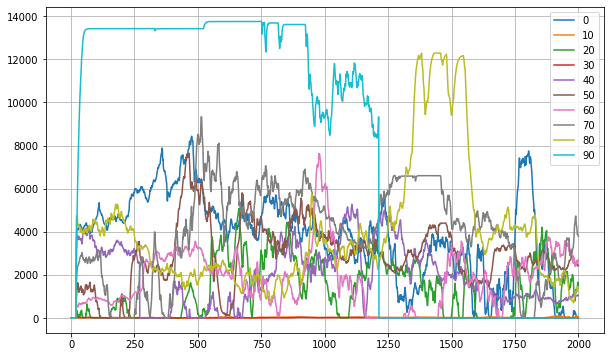

In [72]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(shares[i, :, 0])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(shares[i, :, 1])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

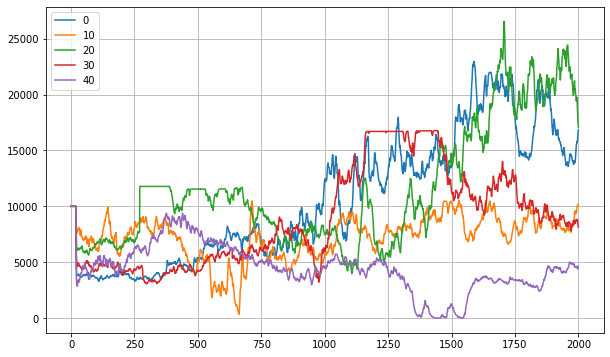

In [73]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//5):
    plt.plot(balances[i])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

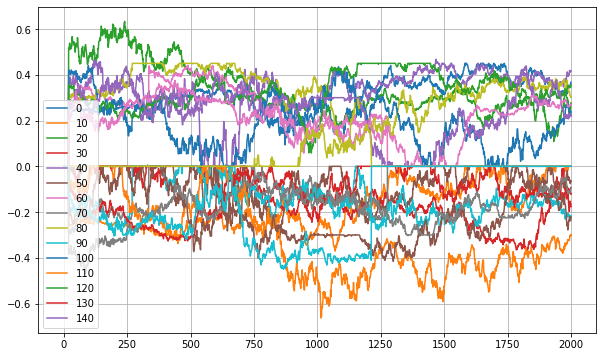

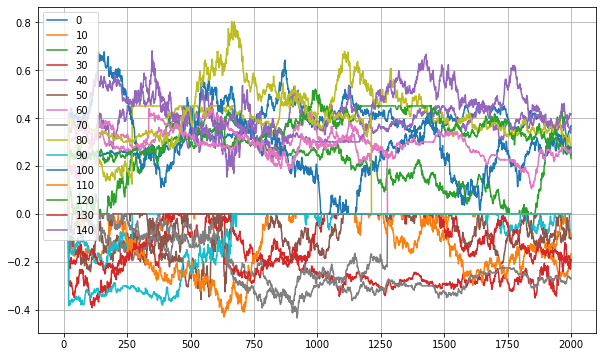

In [74]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(actions[i, :, 0])
    plt.plot(-actions[i,:, 2])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(actions[i, :, 1])
    plt.plot(-actions[i,:, 3])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

In [10]:
files = np.random.choice(stocks,2)
print(files)
files = ['AAPL.csv','PCG.csv']
def test(env,agent):
    print(agent.num_steps)
    max_steps = env.max_steps
    profitst = np.zeros(max_steps)
    balancest = np.zeros( max_steps + 1)
    sharest = np.zeros((max_steps+1, agent.action_dimensions))
    actionst = np.zeros((max_steps+1, agent.action_dimensions*2))
    profit = 0
    observation, info = env.reset(intial_balance = 20000)
    balancest[0] = info['balance']
#         print(info['balance'])
    sharest[0] = info['shares_held']
#         print(info['shares_held'])
    agent.agent_start()
    action = agent.agent_step(0,observation)
    actionst[0] = action

    for i in tqdm(range(max_steps)):
        observation, reward, done, info = env.step(action)
        profit += reward
        profitst[i] = env.net_worth
        balancest[i+1] = info['balance']
        sharest[i+1] = info['shares_held']
        #print(action)
        #print('state',agent.state)
        if done:
            break
#         if i%500 ==0:
#             print(i)
        action = agent.agent_step(reward, observation)
        actionst[i+1] = action
#             print('o',action)
    print(profitst[i-1])
#     print('Completed' + str(count) + 'values')

    return profitst, balancest, sharest, actionst


['INFY.csv' 'AMZN.csv']


In [ ]:
stocks = ['IBM.csv','GOOG.csv', 'AAPL.csv', 'MSFT.csv','AMZN.csv','DXC.csv','INFY.csv','M.csv','PCG.csv', 'PNB.csv', 'RELIN.csv','BPCL.csv']
files = np.random.choice(stocks,2)
files[0] = files[1]
print(files)
env = create_stock_env(files, train = False)
agent = Agent(AGENT_PARAMS, train = False, resume = True)
profitst1, balancest1, sharest1, actionst1 = test(env,agent)

env = create_stock_env(files, train = False)
agent = Agent(AGENT_PARAMS, train = True
              , resume = False)
profitst, balancest, sharest, actionst = test(env,agent)

df1 = pd.read_csv(files[0])
df2 = pd.read_csv(files[1])
plt.figure(figsize = [15, 10])

plt.plot(profitst1[:])
plt.plot(profitst[:])
plt.plot(df1.loc[:,'High']*20000/df1.loc[0,'Low'])
plt.plot(df2.loc[:,'High']*20000/df2.loc[0,'Low'])
plt.grid()
plt.title('profit')
plt.legend(['agent','random agent','follow '+files[0],'follow '+files[1]])
plt.show()

['PNB.csv' 'PNB.csv']
loading
Successfully Loaded


  0%|          | 0/2572 [00:00<?, ?it/s]

0
current_step 0


  0%|          | 0/2572 [00:00<?, ?it/s]

11572.591679113308
0
current_step 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

 74%|███████▍  | 1898/2572 [01:27<00:29, 23.10it/s]

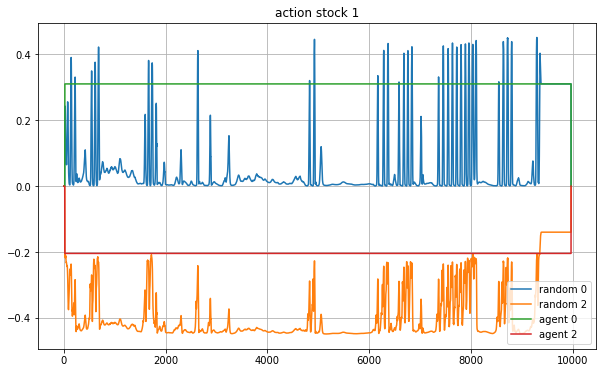

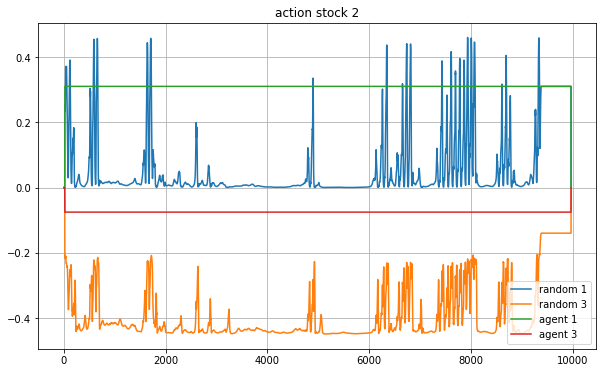

In [131]:
plt.figure(figsize = [10, 6])
plt.plot(actionst[:,0])
plt.plot(-actionst[:,2])
plt.plot(actionst1[:,0])
plt.plot(-actionst1[:,2])
plt.legend(['random 0','random 2','agent 0','agent 2'])
plt.grid()
plt.title('action stock 1')
plt.show()
    
plt.figure(figsize = [10, 6])
plt.plot(actionst[:,1])
plt.plot(-actionst[:,3])
plt.plot(actionst1[:,1])
plt.plot(-actionst1[:,3])
plt.grid()
plt.legend(['random 1','random 3','agent 1','agent 3'])
plt.title('action stock 2')
plt.show()

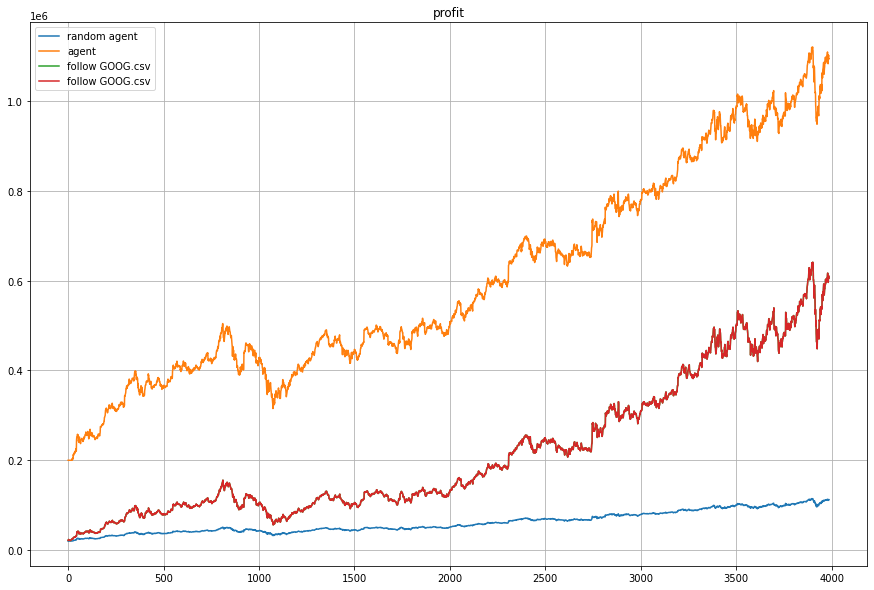

In [106]:
df1 = pd.read_csv(files[0])
df2 = pd.read_csv(files[1])
plt.figure(figsize = [15, 10])
plt.plot(profitst[:])
plt.plot(profitst1[:]*10)
plt.plot(df1.loc[:env.max_steps,'High']*20000/df1.loc[0,'Low'])
plt.plot(df2.loc[:env.max_steps,'High']*20000/df2.loc[0,'Low'])
plt.legend(['random agent','agent','follow '+files[0],'follow '+files[1]])
plt.grid()
plt.title('profit')
plt.show()

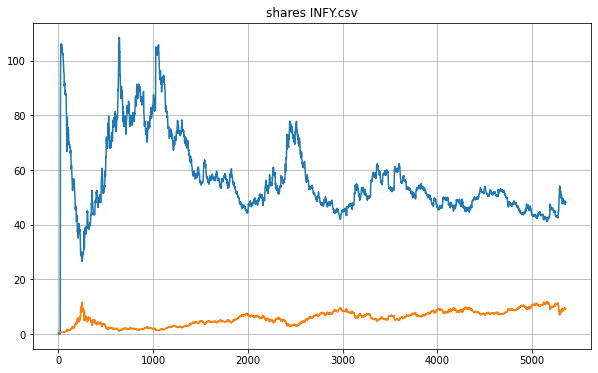

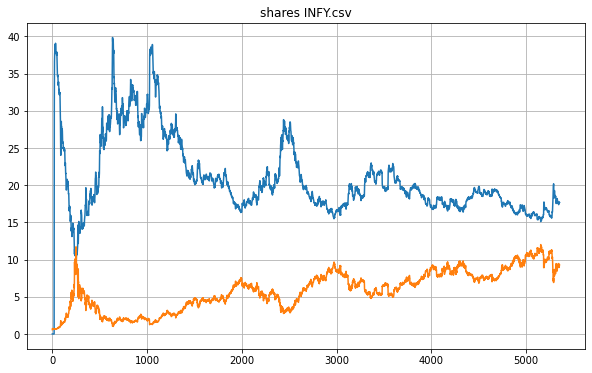

In [661]:
for count,i in enumerate(files):
    plt.figure(figsize = [10, 6])
    plt.plot(sharest[:, count]*0.01)
    df = pd.read_csv(i)
    plt.plot(df['Open'])
    plt.grid()
    plt.title('shares '+i)
    plt.show()

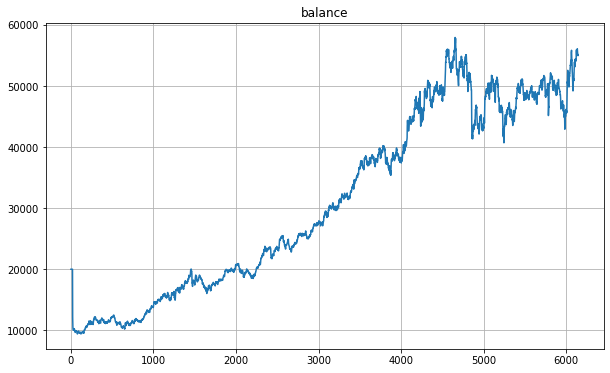

In [610]:
plt.figure(figsize = [10, 6])
plt.plot(balancest[:])
plt.grid()
plt.title('balance')
plt.show()

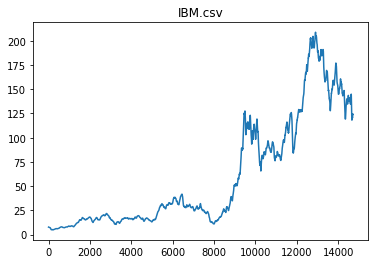

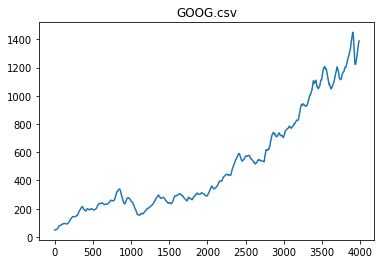

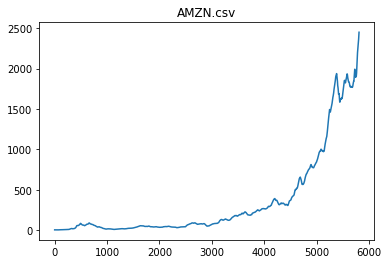

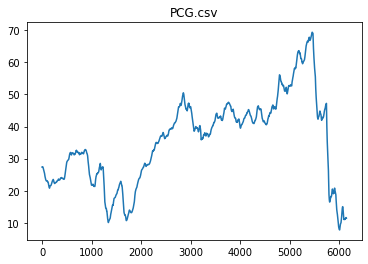

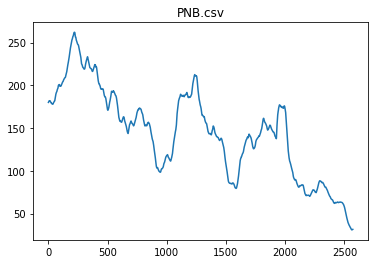

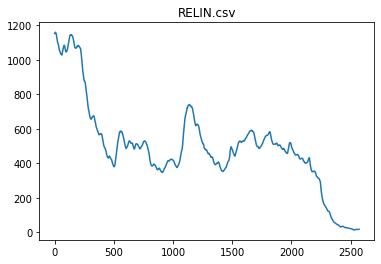

In [31]:
for i in stocks:
    df = pd.read_csv(i)
    #plt.plot(df['Open'])
    x = list(df['Open'])
    for j in range(1,len(x)):
        x[j] = 0.05*x[j] + 0.95*x[j-1]
    plt.plot(x)
    plt.title(i)
    plt.show()

    
#dxc,m,pcg   
#IBM
#infy
#google,aapl,msft,amzn

In [188]:
for att in vars(agent):
    print (att, getattr(agent,att))
print('--------------------------------------------------------------------------------------------------')
for att in vars(agent.actor):
    print (att, getattr(agent.actor,att))
print('--------------------------------------------------------------------------------------------------')
# print(--------------------------------------------------------------------------------------------------------)
for att in vars(agent.critic):
    print (att, getattr(agent.critic,att)) 
print('--------------------------------------------------------------------------------------------------')
#print(--------------------------------------------------------------------------------------------------------)
for att in vars(env):
    print (att, getattr(env,att))
print('--------------------------------------------------------------------------------------------------')
#     print(--------------------------------------------------------------------------------------------------------)

for name in vars().keys():
    print(name)

back_state 1
train True
actor <__main__.Actor object at 0x7f52b4daaf90>
critic <__main__.Critic object at 0x7f52b409f810>
buffer <__main__.ReplayMemory object at 0x7f52a6b560d0>
state_dimensions 16
action_dimensions 3
discount 0.99
action_range 1
save_frequency 5000
batch_size 64
optimizer <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f52b45c2ed0>
cap 0.9
num_steps 0
state [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
have_state 1
noise_func OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0.], sigma=0.3)
--------------------------------------------------------------------------------------------------
output_range 1
state_dimensions 16
action_dimensions 3
cap 0.9
actor <tensorflow.python.keras.engine.training.Model object at 0x7f52b4b90150>
--------------------------------------------------------------------------------------------------
state_dimensions 16
action_dimensions 3
optimizer <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f52b405f090>
tau 0